# Library


In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
import time
from scipy.io import mmread
import seaborn as sns
import matplotlib.pyplot as plt


# Utility function

In [2]:
def lmo(grad):
    i = np.argmin(grad)
    s = np.zeros_like(grad)
    s[i] = 1.0
    return s, i

def projection_simplex(v, z=1):
    n_features = v.shape[0]
    
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u * ind > cssv
    
    if np.sum(cond) > 0:
        rho = ind[cond][-1]
        theta = cssv[cond][-1] / float(rho)
        w = np.maximum(v - theta, 0)
    else:
        w = np.zeros_like(v)
        if v.size > 0: w[np.argmax(v)] = z
            
    return w

def extract_clique(x, A):
    if x is None or not np.all(np.isfinite(x)):
        return []
    
    support_indices = np.where(x > 1e-3)[0]
    if len(support_indices) == 0: 
        return []
    
    # Ordina gli indici dei nodi per peso decrescente
    sorted_support = support_indices[np.argsort(-x[support_indices])]
    
    clique = []
    for i in sorted_support:
        # Verifica se il nodo i è connesso a tutti i nodi già nella cricca
        is_connected_to_all = all(A[i, j] == 1 for j in clique)
        if is_connected_to_all:
            clique.append(i)
    return clique

def validate_clique(clique, A):
    """Verifica se un dato insieme di nodi forma una cricca."""
    if len(clique) <= 1: 
        return True

    subgraph = A[np.ix_(clique, clique)]
    # In una cricca, tutti gli elementi fuori diagonale devono essere 1.
    # La somma deve essere il numero di archi in un grafo completo.
    expected_edges = len(clique) * (len(clique) - 1)
    return np.sum(subgraph) == expected_edges


def load_graph(filepath):
    """Carica un grafo da file .mtx e restituisce la sua matrice di adiacenza."""
    sparse_matrix = mmread(filepath)

    n = sparse_matrix.shape[0]
    A = sparse_matrix.astype(int).toarray()
    
    # Assicura che sia una matrice di adiacenza 0/1, simmetrica, con diagonale nulla
    A = np.ceil((A + A.T) / 2.0).astype(int)
    np.fill_diagonal(A, 0)
    return A

# Objective Functions

In [3]:
def f_l2(x, A, alpha=0.5): 
    return x.T @ A @ x + alpha * np.dot(x, x)

def grad_l2(x, A, alpha=0.5): 
    return 2 * A @ x + alpha * 2 * x

def f_l0(x, A, alpha=0.07, beta=5): 
    return x.T @ A @ x + alpha * np.sum(np.exp(-beta * x) - 1)

def grad_l0(x, A, alpha=0.07, beta=5): 
    return 2 * A @ x - alpha * beta * np.exp(-beta * x)

# Step Size

In [4]:
def exact_line_search(objective_func, x_curr, d_curr, A_matrix, grad_f_x, gamma_max=1.0, **obj_kwargs):
    """Ricerca lineare esatta ("Optimal Gamma")."""
    if np.linalg.norm(d_curr) < 1e-12: 
        return 0.0
    
    def func_to_minimize(gamma_ls):
        val = objective_func(x_curr + gamma_ls * d_curr, A_matrix, **obj_kwargs)
        return -val # Minimizza il negativo per massimizzare l'obiettivo
        
    if not (np.isfinite(gamma_max) and gamma_max >= 0):
        gamma_max = 1.0

    if gamma_max < 1e-12:
        return 0.0
    
    try:
        res = minimize_scalar(func_to_minimize, bounds=(0, gamma_max), method='bounded')
        gamma = res.x
        if not np.isfinite(gamma): 
            gamma = 0.0
    except Exception:
        gamma = 0.0
        
    return np.clip(gamma, 0.0, gamma_max)

def armijo_line_search(objective_func, x_curr, d_curr, A_matrix, grad_f_x, gamma_max=1.0, **obj_kwargs):
    """Ricerca lineare inesatta con regola di Armijo e backtracking."""
    if np.linalg.norm(d_curr) < 1e-12: return 0.0
    
    gamma = gamma_max  # Inizia con il passo massimo possibile
    c1 = 1e-4          # Parametro standard di Armijo
    tau = 0.5          # Fattore di riduzione del backtracking
    
    f_x = objective_func(x_curr, A_matrix, **obj_kwargs)
    progress_expected = np.dot(grad_f_x, d_curr)

    # La direzione deve essere di salita per la massimizzazione
    if progress_expected <= 0:
        return 0.0 

    for _ in range(20): # Limita le iterazioni del backtracking
        f_x_new = objective_func(x_curr + gamma * d_curr, A_matrix, **obj_kwargs)
        # Condizione di Armijo per la massimizzazione
        if f_x_new >= f_x + c1 * gamma * progress_expected:
            return gamma
        gamma *= tau
        
    return 0.0 # Il backtracking non ha trovato un passo valido


# Algorithms

# Fank-Wolfe

In [5]:
def frank_wolfe(A, reg_type, max_iter, tol, step_func):
    """Implementazione del Frank-Wolfe Classico."""
    n = A.shape[0]
    
    x0_idx = np.random.randint(n)
    x = np.zeros(n)
    x[x0_idx] = 1.0
    
    if reg_type == 'l2':
        obj_func = f_l2
        grad_func = grad_l2
        obj_kwargs = {'alpha': 0.5}
    else:
        obj_func = f_l0
        grad_func = grad_l0
        obj_kwargs = {'alpha': 0.07, 'beta': 5}
    
    history = [obj_func(x, A, **obj_kwargs)]
    x_best = np.copy(x)
    f_best = history[0]
    
    for t in range(max_iter):
        grad = grad_func(x, A, **obj_kwargs)
        s_vertex, _ = lmo(-grad)
        d = s_vertex - x
        gap = np.dot(grad, d)
        if gap < tol: break
        
        gamma = step_func(obj_func, x, d, A, grad, 1.0, **obj_kwargs)
        x = (1 - gamma) * x + gamma * s_vertex

        current_f = obj_func(x, A, **obj_kwargs)
        history.append(current_f)
        if current_f > f_best:
            f_best = current_f
            x_best = np.copy(x)
            
    return x_best, history


# Pairwise Frank-Wolfe

In [6]:
def pairwise_frank_wolfe(A, reg_type, max_iter, tol, step_func):
    """Implementazione Corretta del Pairwise Frank-Wolfe."""
    n = A.shape[0]

    x0_idx = np.random.randint(n)
    x = np.zeros(n)
    x[x0_idx] = 1.0
    
    if reg_type == 'l2':
        obj_func = f_l2
        grad_func = grad_l2
        obj_kwargs = {'alpha': 0.5}
    else:
        obj_func = f_l0
        grad_func = grad_l0
        obj_kwargs = {'alpha': 0.07, 'beta': 5}
        
    history = [obj_func(x, A, **obj_kwargs)]
    x_best = np.copy(x)
    f_best = history[0]
    
    for t in range(max_iter):
        grad = grad_func(x, A, **obj_kwargs)
        s_vertex, s_idx = lmo(-grad)
        d_gap_vec = s_vertex - x
        gap = np.dot(grad, d_gap_vec)
        if gap < tol:
            break
        
        support = np.where(x > 1e-9)[0]
        if not len(support):
            x.fill(0.0); x[s_idx] = 1.0
            history.append(obj_func(x, A, **obj_kwargs))
            continue
            
        v_idx = support[np.argmin(grad[support])]
        
        if s_idx == v_idx:
            d = s_vertex - x
            gamma_max = 1.0
        else:
            v_vertex = np.zeros(n); v_vertex[v_idx] = 1.0
            d = s_vertex - v_vertex
            gamma_max = x[v_idx]
        
        gamma = step_func(obj_func, x, d, A, grad, gamma_max, **obj_kwargs)
        
        if s_idx == v_idx:
            x = (1.0 - gamma) * x + gamma * s_vertex
        else:
            x[s_idx] += gamma
            x[v_idx] -= gamma
        
        x[x<1e-10] = 0.0
        if np.sum(x) > 1e-9:
            x /= np.sum(x)
            
        current_f = obj_func(x, A, **obj_kwargs)
        history.append(current_f)
        if current_f > f_best:
            f_best = current_f
            x_best = np.copy(x)

    return x_best, history

# Away-step Frank-Wolfe

In [7]:
def away_step_frank_wolfe(A, reg_type, max_iter, tol, step_func):
    """Implementazione Corretta dell'Away-Step Frank-Wolfe."""
    n = A.shape[0]
    
    x0_idx = np.random.randint(n)
    x = np.zeros(n)
    x[x0_idx] = 1.0
    
    if reg_type == 'l2':
        obj_func = f_l2
        grad_func = grad_l2
        obj_kwargs = {'alpha': 0.5}
    else:
        obj_func = f_l0
        grad_func = grad_l0
        obj_kwargs = {'alpha': 0.07, 'beta': 5}
        
    history = [obj_func(x, A, **obj_kwargs)]
    x_best = np.copy(x)
    f_best = history[0]
    
    for t in range(max_iter):
        grad = grad_func(x, A, **obj_kwargs)
        s_vertex, s_idx = lmo(-grad)
        d_fw = s_vertex - x
        gap_fw = np.dot(grad, d_fw)
        if gap_fw < tol: break
        
        support = np.where(x > 1e-9)[0]
        if not len(support):
            x.fill(0.0); x[s_idx] = 1.0
            history.append(obj_func(x, A, **obj_kwargs))
            continue
            
        v_idx = support[np.argmin(grad[support])]
        v_vertex = np.zeros(n); v_vertex[v_idx] = 1.0
        d_away = x - v_vertex
        progress_away = np.dot(grad, d_away)
        
        if gap_fw >= progress_away:
            d = d_fw
            gamma_max = 1.0
        else:
            d = d_away
            alpha_v = x[v_idx]
            gamma_max = alpha_v / (1.0 - alpha_v) if abs(1.0 - alpha_v) > 1e-9 else float('inf')
        
        gamma = step_func(obj_func, x, d, A, grad, gamma_max, **obj_kwargs)
        
        # L'aggiornamento per AFW è x_new = x + gamma*d
        x = x + gamma * d
        
        x[x<1e-10] = 0.0
        if np.sum(x) > 1e-9:
            x /= np.sum(x)
            
        current_f = obj_func(x, A, **obj_kwargs)
        history.append(current_f)
        if current_f > f_best:
            f_best = current_f
            x_best = np.copy(x)
    
    return x_best, history


# Projected Gradient

In [8]:
def projected_gradient(A, reg_type, max_iter, tol, step_func, lr_initial=0.5):
    """Implementazione del Gradiente Proiettato."""
    n = A.shape[0]
    
    x0_idx = np.random.randint(n)
    x = np.zeros(n)
    x[x0_idx] = 1.0
    
    if reg_type == 'l2':
        obj_func = f_l2
        grad_func = grad_l2
        obj_kwargs = {'alpha': 0.5}
    else:
        obj_func = f_l0
        grad_func = grad_l0
        obj_kwargs = {'alpha': 0.07, 'beta': 5}
        
    history = [obj_func(x, A, **obj_kwargs)]
    x_best = np.copy(x)
    f_best = history[0]
    
    for t in range(max_iter):
        grad = grad_func(x, A, **obj_kwargs)
        
        # Per PGD la direzione è il gradiente. Il passo Armijo è una scelta valida.
        gamma = step_func(obj_func, x, grad, A, grad, lr_initial, **obj_kwargs)
        
        x_next = projection_simplex(x + gamma * grad)
        if np.linalg.norm(x_next - x) < tol:
            break
        x = x_next
        
        current_f = obj_func(x, A, **obj_kwargs)
        history.append(current_f)
        if current_f > f_best:
            f_best = current_f
            x_best = np.copy(x)
            
    return x_best, history

# Experiments execution

In [10]:
graph_files = [
    "./data/C250-9.mtx",
    "./data/C500-9.mtx",
    "./data/C2000-9.mtx",
]
reg_types = ['l2', 'l0']
algorithms = {
    'FW': frank_wolfe,
    'PFW': pairwise_frank_wolfe,
    'AFW': away_step_frank_wolfe,
    'PGD': projected_gradient
}

stepsize_options = [
    {'label': 'Optimal Gamma (LS)', 'func': exact_line_search},
    {'label': 'Armijo Rule', 'func': armijo_line_search},
    {'label': 'Fixed Gamma = 0.05', 'func': lambda obj, x, d, A, grad, g_max, **kwargs: min(0.05, g_max)}
]

results_list = []

for graph_file in graph_files:
    print(f"\n--- File Processing: {graph_file} ---")
    A = load_graph(graph_file)
    if A is None: continue
    print(f"Graph loaded with {A.shape[0]} nodes.")

    # Il multi-start è importante per i problemi non convessi
    num_random_starts = 5 # Aumenta per un'analisi più robusta

    for step_info in stepsize_options:
        step_func = step_info['func']
        step_label = step_info['label']

        print(f"--- Execution with step strategy: {step_label} ---")
        for reg_type in reg_types:
            for algo_name, algo_func in algorithms.items():
                print(f"Execution: {algo_name} - Reg: {reg_type}")

                best_clique_size_for_algo = 0
                best_x_for_algo = None
                best_history_for_algo = [] # Aggiunto per salvare la history migliore
                total_runtime = 0

                # FW e PGD partono dal centro, non necessitano di multi-start in questo setup
                starts_to_run = num_random_starts if algo_name in ['PFW', 'AFW'] else 1

                for i in range(starts_to_run):
                    try:
                        start_time = time.perf_counter()

                        x_result, history = algo_func(A=A, reg_type=reg_type, max_iter=100, tol=1e-5, step_func=step_func)

                        runtime = time.perf_counter() - start_time
                        total_runtime += runtime

                        clique = extract_clique(x_result, A)
                        if len(clique) > best_clique_size_for_algo:
                            if validate_clique(clique, A):
                                best_clique_size_for_algo = len(clique)
                                best_x_for_algo = x_result # Salva il vettore soluzione migliore
                                best_history_for_algo = history # Salva la history migliore

                    except Exception as e:
                        print(f"ERROR during execution {algo_name}: {e}")

                # Salva il risultato migliore del multi-start
                if best_x_for_algo is not None:
                        clique = extract_clique(best_x_for_algo, A)
                        is_valid = validate_clique(clique, A)
                        results_list.append({
                        'Graph File': graph_file.split('/')[-1],
                        'Algorithm': algo_name,
                        'Reg': reg_type,
                        'Stepsize': step_label,
                        'Clique Size': len(clique),
                        'Valid': is_valid,
                        'Runtime (s)': total_runtime / starts_to_run,
                        'History': best_history_for_algo 
                        })
                else: 
                        results_list.append({
                        'Graph File': graph_file.split('/')[-1],
                        'Algorithm': algo_name,
                        'Reg': reg_type,
                        'Stepsize': step_label,
                        'Clique Size': 0,
                        'Valid': False,
                        'Runtime (s)': total_runtime / starts_to_run,
                        'History': [] 
                        })


# Stampa riepilogo tabellare
print("\n" + "="*85)
print("                              FINAL SUMMARY OF RESULTS                              ")
print("="*85)
if results_list:
    df_results = pd.DataFrame(results_list)
    print(df_results.to_string())
else:
    print("No results to display.")
print("="*85)


--- File Processing: ./data/C250-9.mtx ---
Graph loaded with 250 nodes.
--- Execution with step strategy: Optimal Gamma (LS) ---
Execution: FW - Reg: l2
Execution: PFW - Reg: l2
Execution: AFW - Reg: l2
Execution: PGD - Reg: l2
Execution: FW - Reg: l0
Execution: PFW - Reg: l0
Execution: AFW - Reg: l0
Execution: PGD - Reg: l0
--- Execution with step strategy: Armijo Rule ---
Execution: FW - Reg: l2
Execution: PFW - Reg: l2
Execution: AFW - Reg: l2
Execution: PGD - Reg: l2
Execution: FW - Reg: l0
Execution: PFW - Reg: l0
Execution: AFW - Reg: l0
Execution: PGD - Reg: l0
--- Execution with step strategy: Fixed Gamma = 0.05 ---
Execution: FW - Reg: l2
Execution: PFW - Reg: l2
Execution: AFW - Reg: l2
Execution: PGD - Reg: l2
Execution: FW - Reg: l0
Execution: PFW - Reg: l0
Execution: AFW - Reg: l0
Execution: PGD - Reg: l0

--- File Processing: ./data/C500-9.mtx ---
Graph loaded with 500 nodes.
--- Execution with step strategy: Optimal Gamma (LS) ---
Execution: FW - Reg: l2
Execution: PFW 

In [11]:
df_results.to_csv("results.csv")

# Graphs

Generating plots for 72 valid results.


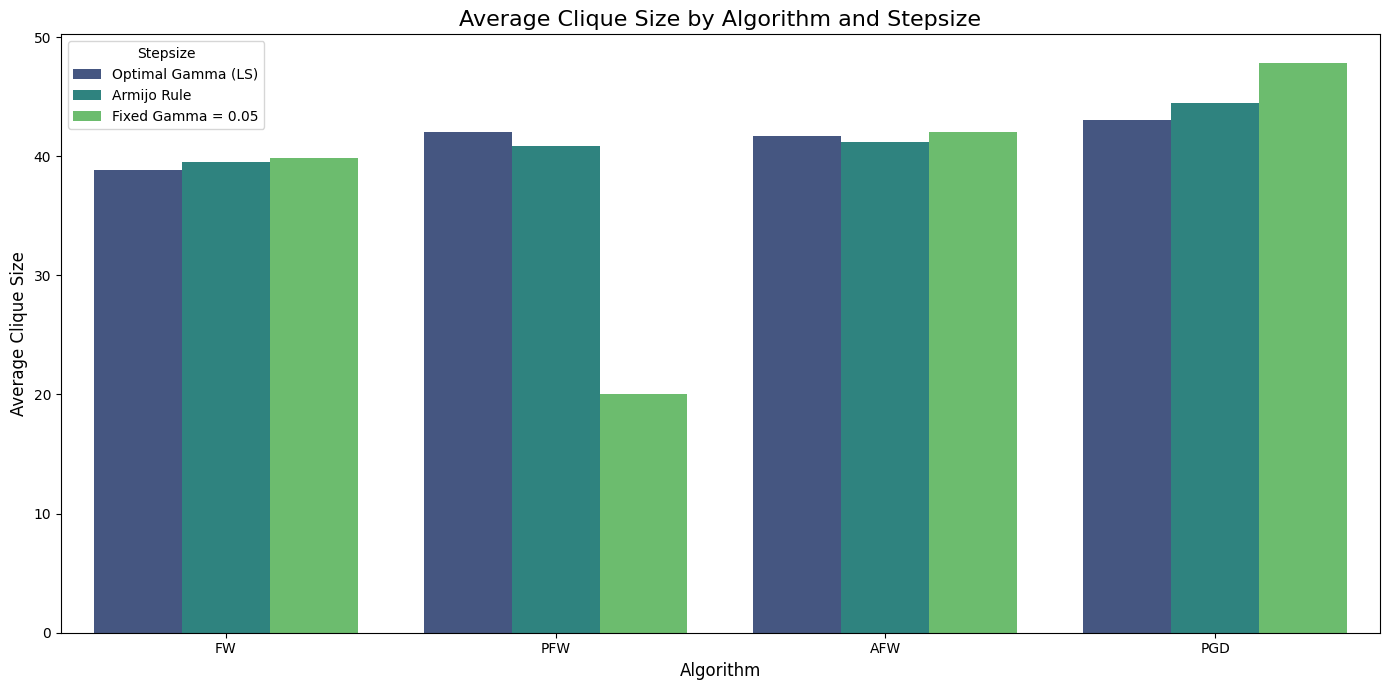

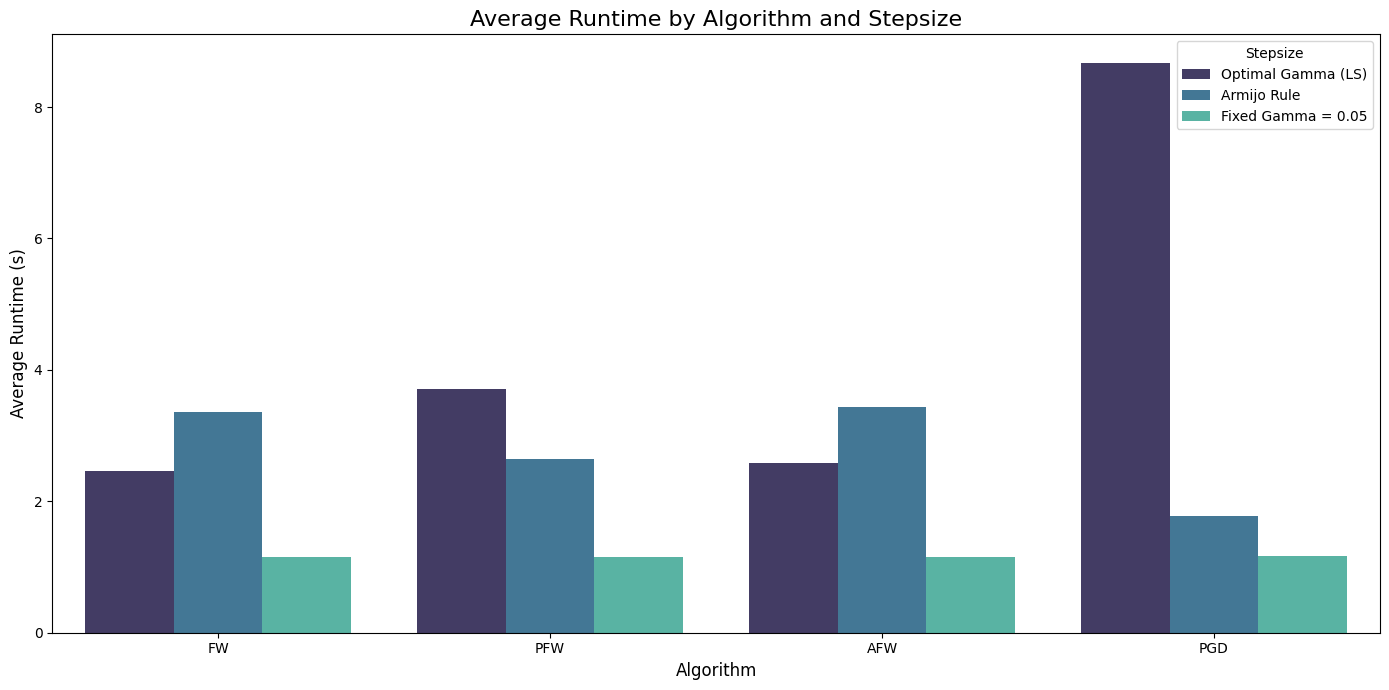

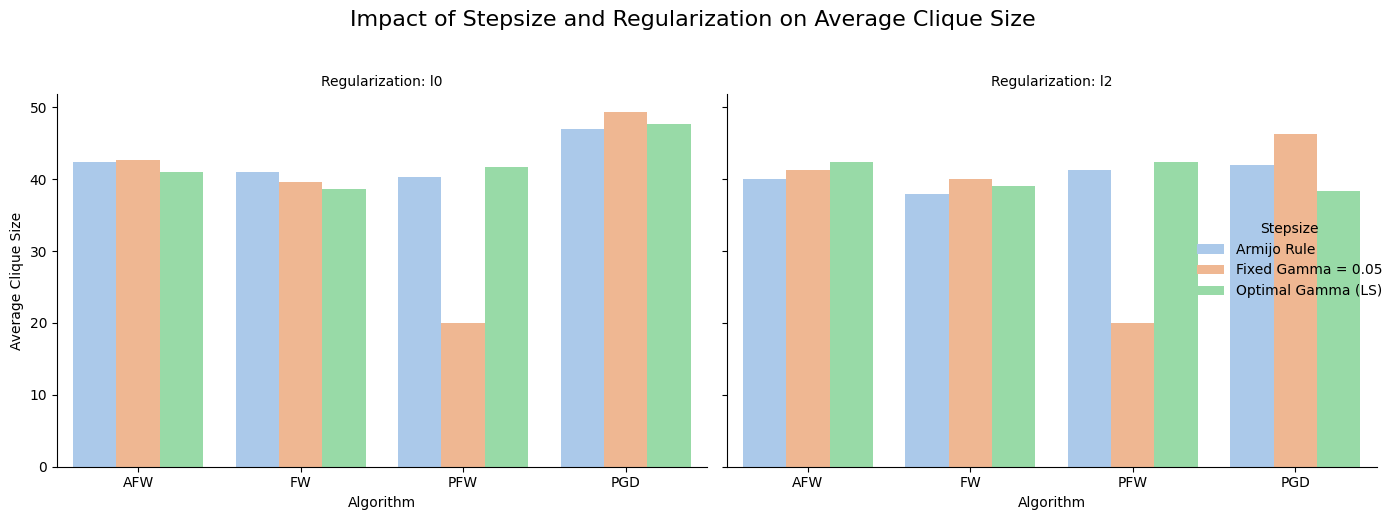

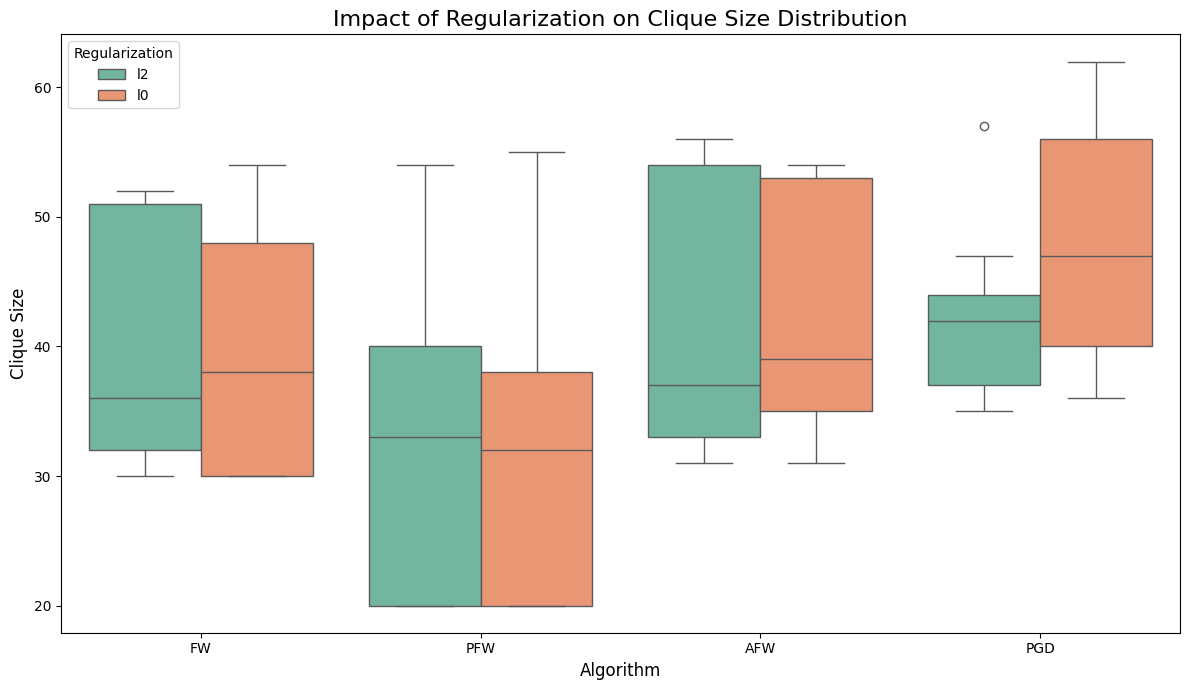

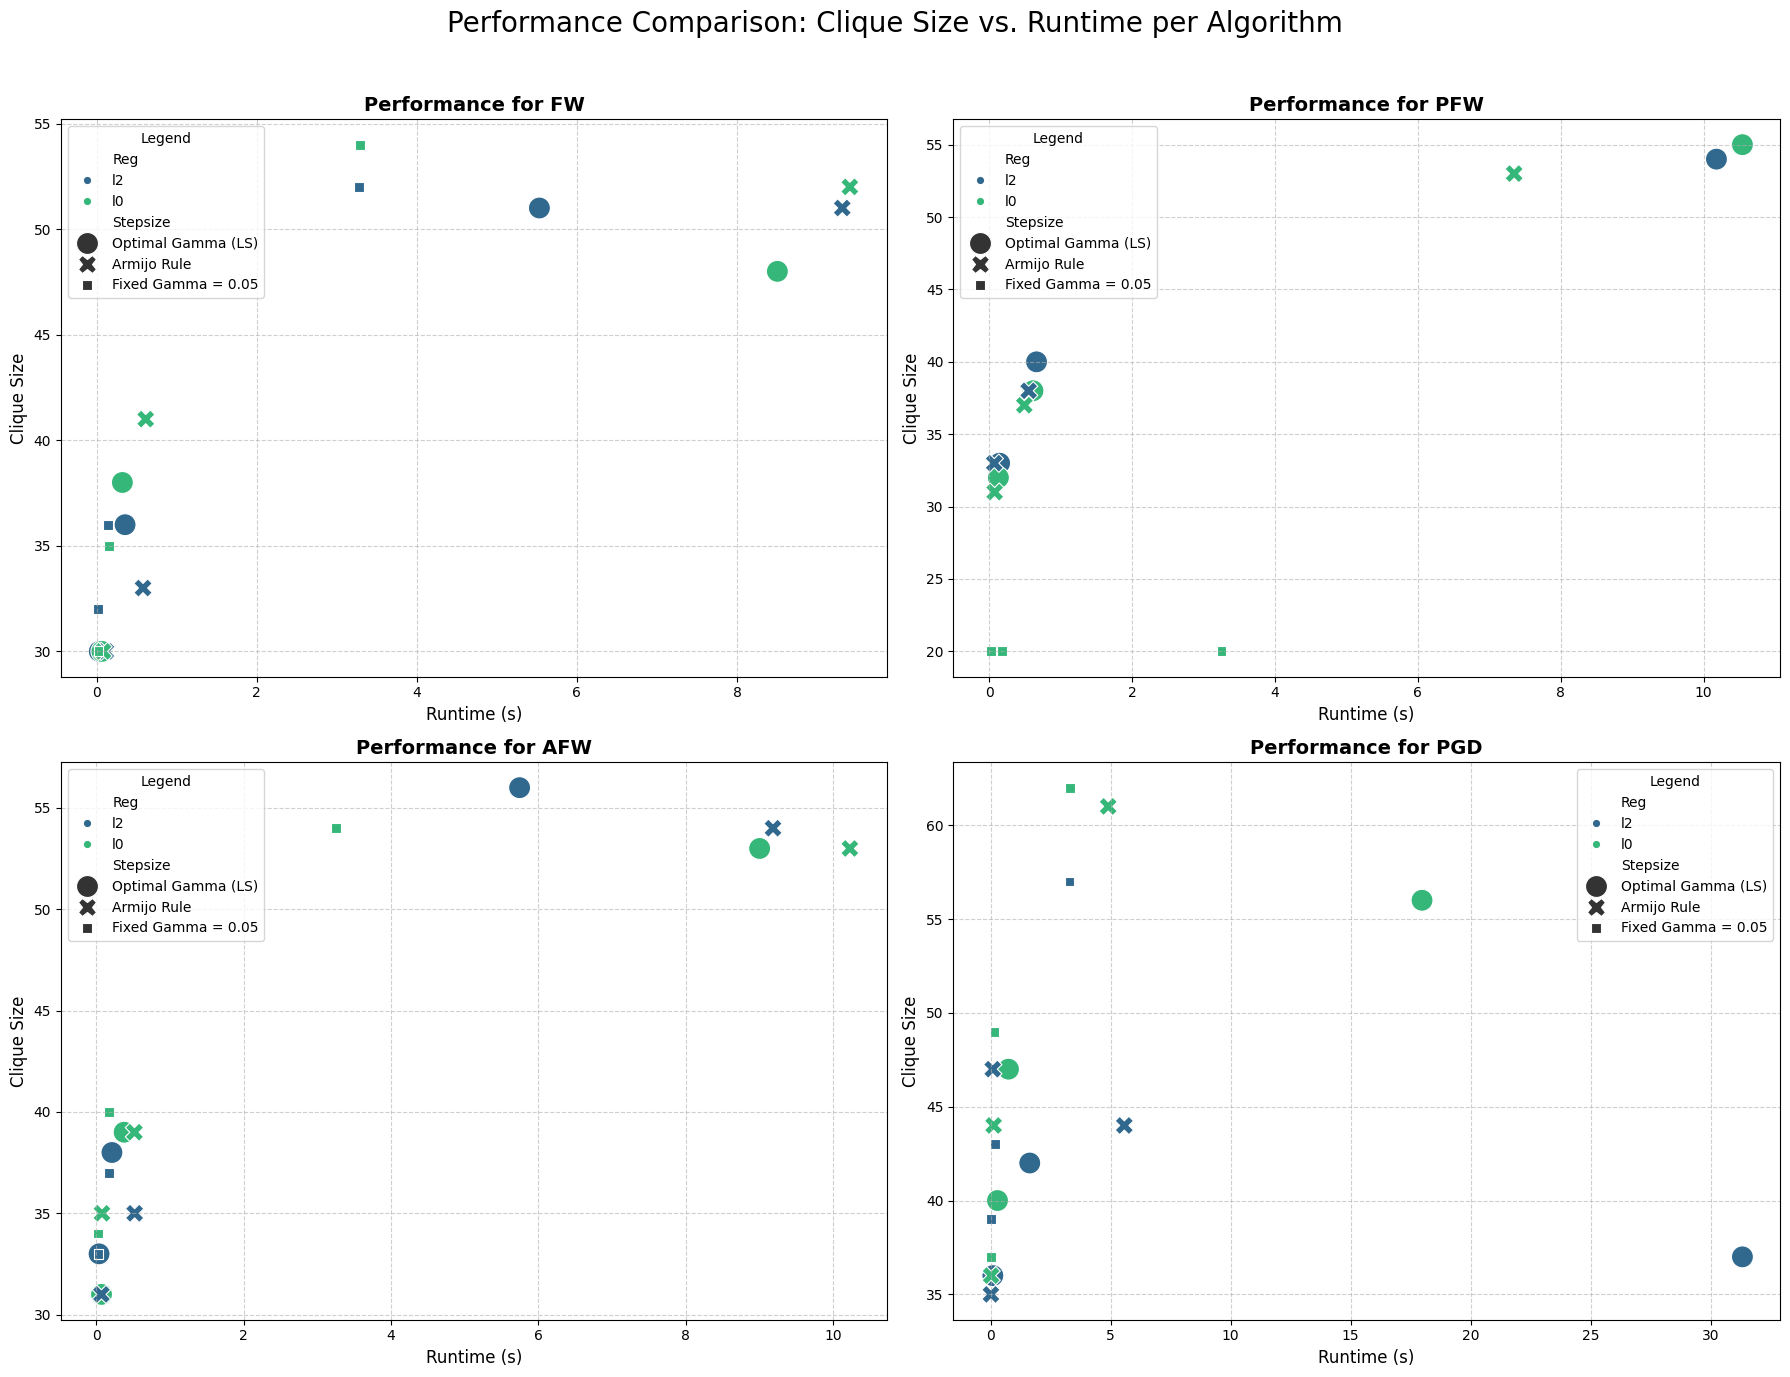

In [12]:
# Ensure df_results is available from previous cells
if 'df_results' not in locals():
    print("DataFrame 'df_results' not found. Please run the previous cell first.")
else:
    # Filter for valid results
    df_valid_results = df_results[df_results['Valid']].copy()

    if df_valid_results.empty:
        print("No valid results found after filtering. Cannot generate plots.")
    else:
        print(f"Generating plots for {len(df_valid_results)} valid results.")

        # --- Plot 1: Clique Size by Algorithm and Stepsize ---
        plt.figure(figsize=(14, 7))
        sns.barplot(data=df_valid_results, x='Algorithm', y='Clique Size', hue='Stepsize', palette='viridis', errorbar=None)
        plt.title('Average Clique Size by Algorithm and Stepsize', fontsize=16)
        plt.xlabel('Algorithm', fontsize=12)
        plt.ylabel('Average Clique Size', fontsize=12)
        plt.xticks(rotation=0) # Keep labels horizontal for clarity
        plt.legend(title='Stepsize')
        plt.tight_layout()
        plt.show()

        # --- Plot 2: Runtime by Algorithm and Stepsize ---
        plt.figure(figsize=(14, 7))
        sns.barplot(data=df_valid_results, x='Algorithm', y='Runtime (s)', hue='Stepsize', palette='mako', errorbar=None)
        plt.title('Average Runtime by Algorithm and Stepsize', fontsize=16)
        plt.xlabel('Algorithm', fontsize=12)
        plt.ylabel('Average Runtime (s)', fontsize=12)
        plt.xticks(rotation=0)
        plt.legend(title='Stepsize')
        plt.tight_layout()
        plt.show()

        # --- Plot 3: Impact of Stepsize and Regularization on Clique Size (Catplot) ---
        # Group data to show mean for catplot
        grouped_clique = df_valid_results.groupby(['Algorithm', 'Reg', 'Stepsize'])['Clique Size'].mean().reset_index()

        if not grouped_clique.empty:
            g = sns.catplot(data=grouped_clique, x='Algorithm', y='Clique Size', hue='Stepsize',
                            col='Reg', kind='bar', palette='pastel', height=5, aspect=1.2)
            g.fig.suptitle('Impact of Stepsize and Regularization on Average Clique Size', y=1.03, fontsize=16)
            g.set_axis_labels("Algorithm", "Average Clique Size")
            g.set_titles("Regularization: {col_name}")
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough data for the 'Impact of Stepsize and Regularization on Clique Size' plot.")

        # --- Plot 4: Impact of Regularization on Clique Size Distribution (Boxplot) ---
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=df_valid_results, x='Algorithm', y='Clique Size', hue='Reg', palette='Set2')
        plt.title('Impact of Regularization on Clique Size Distribution', fontsize=16)
        plt.xlabel('Algorithm', fontsize=12)
        plt.ylabel('Clique Size', fontsize=12)
        plt.xticks(rotation=0)
        plt.legend(title='Regularization')
        plt.tight_layout()
        plt.show()

        # --- Plot 5: Runtime vs Clique Size Scatter Plot Grid ---
        algorithms = df_valid_results['Algorithm'].unique()
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        axes = axes.flatten()

        for i, algo_name in enumerate(algorithms):
            ax = axes[i]
            df_algo = df_valid_results[df_valid_results['Algorithm'] == algo_name]

            sns.scatterplot(
                data=df_algo,
                x='Runtime (s)',
                y='Clique Size',
                hue='Reg',
                style='Stepsize',
                size='Stepsize',
                sizes=(100, 250),
                palette='viridis',
                ax=ax
            )

            ax.set_title(f"Performance for {algo_name}", fontsize=14, weight='bold')
            ax.set_xlabel('Runtime (s)', fontsize=12)
            ax.set_ylabel('Clique Size', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.legend(title='Legend')

        for i in range(len(algorithms), len(axes)):
            fig.delaxes(axes[i])

        fig.suptitle('Performance Comparison: Clique Size vs. Runtime per Algorithm', fontsize=20, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()






# Loss function plot

Generating Objective Function History plots...


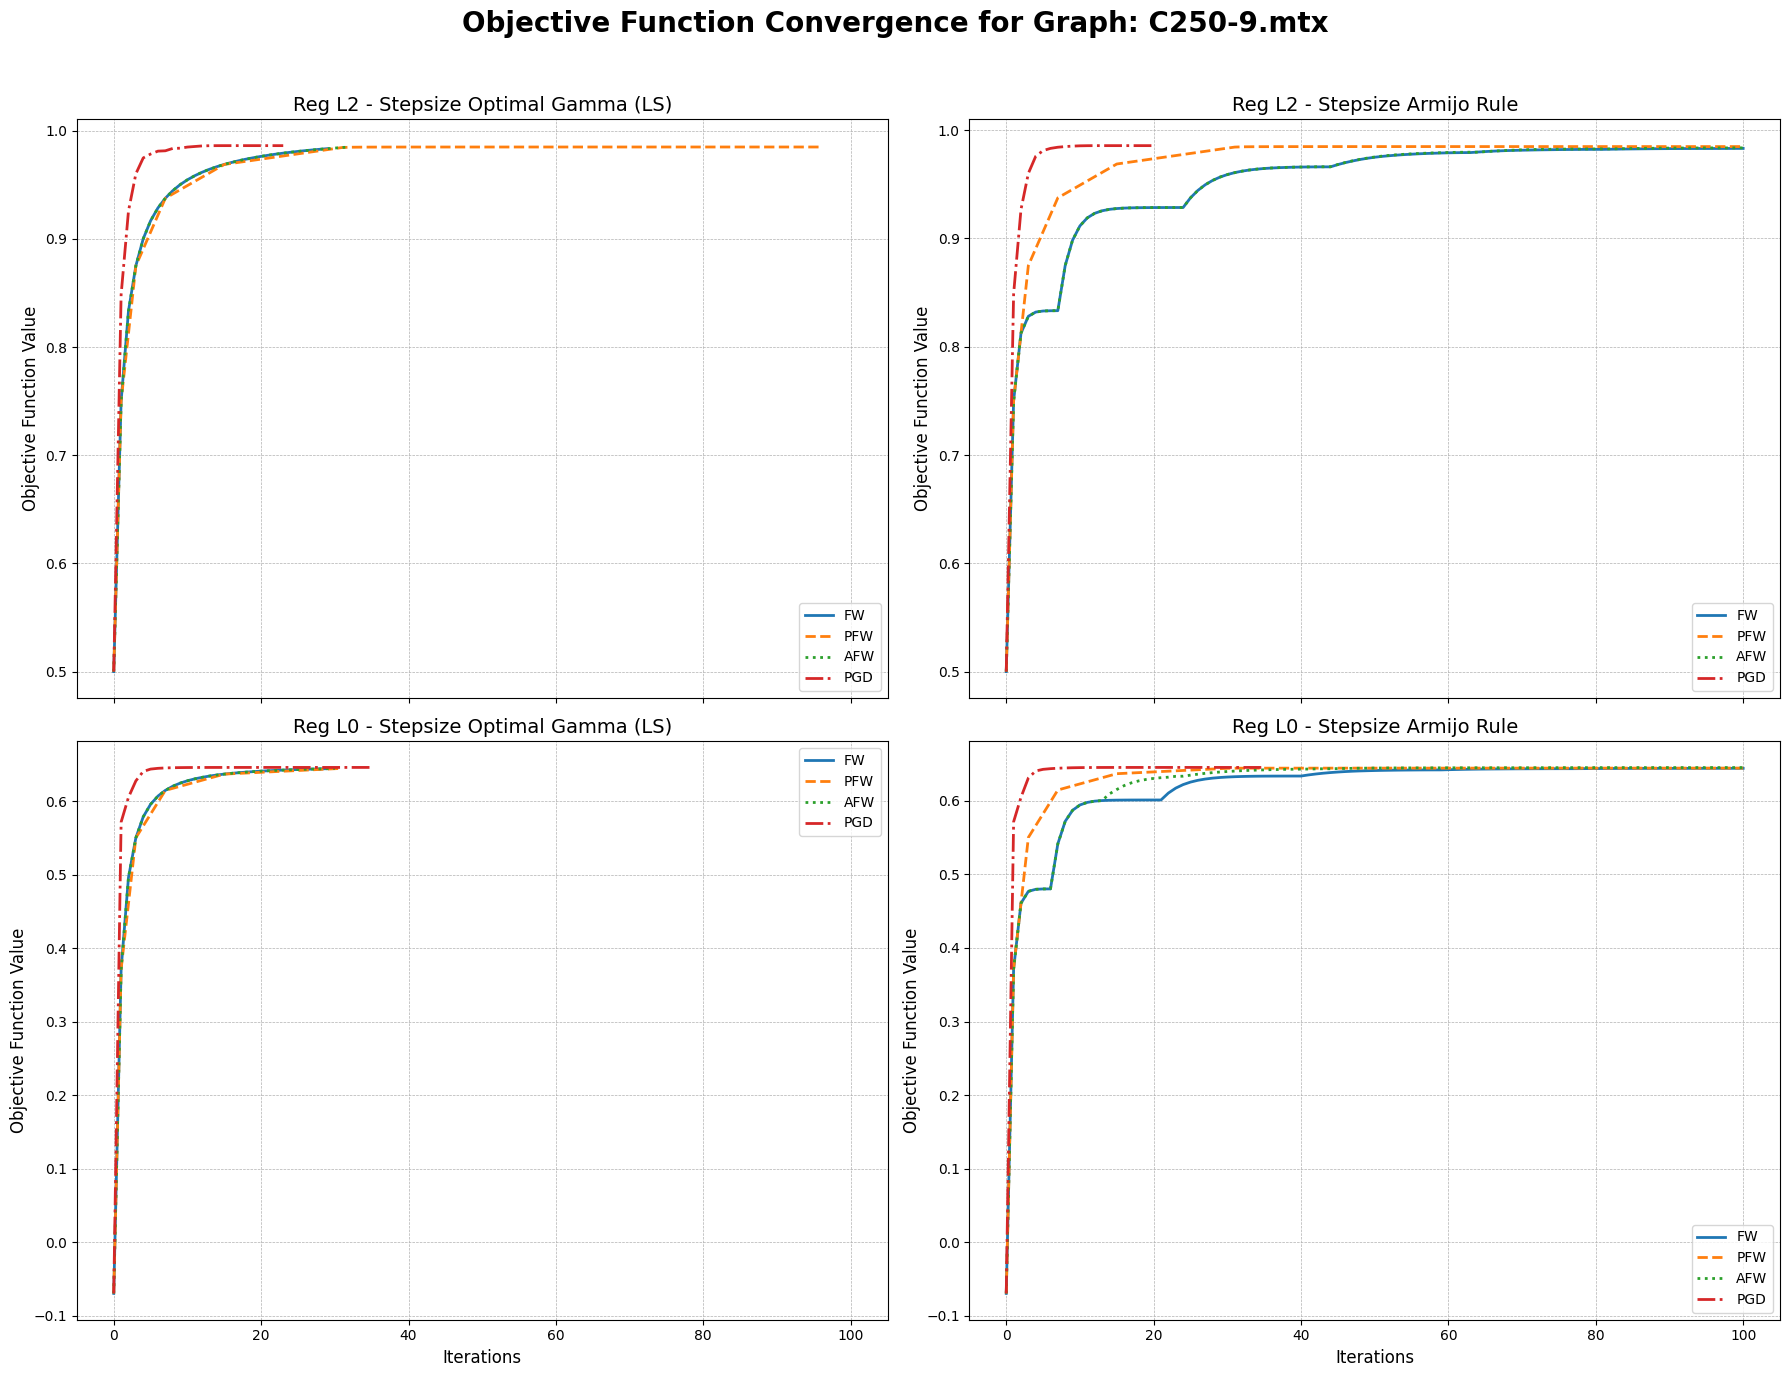

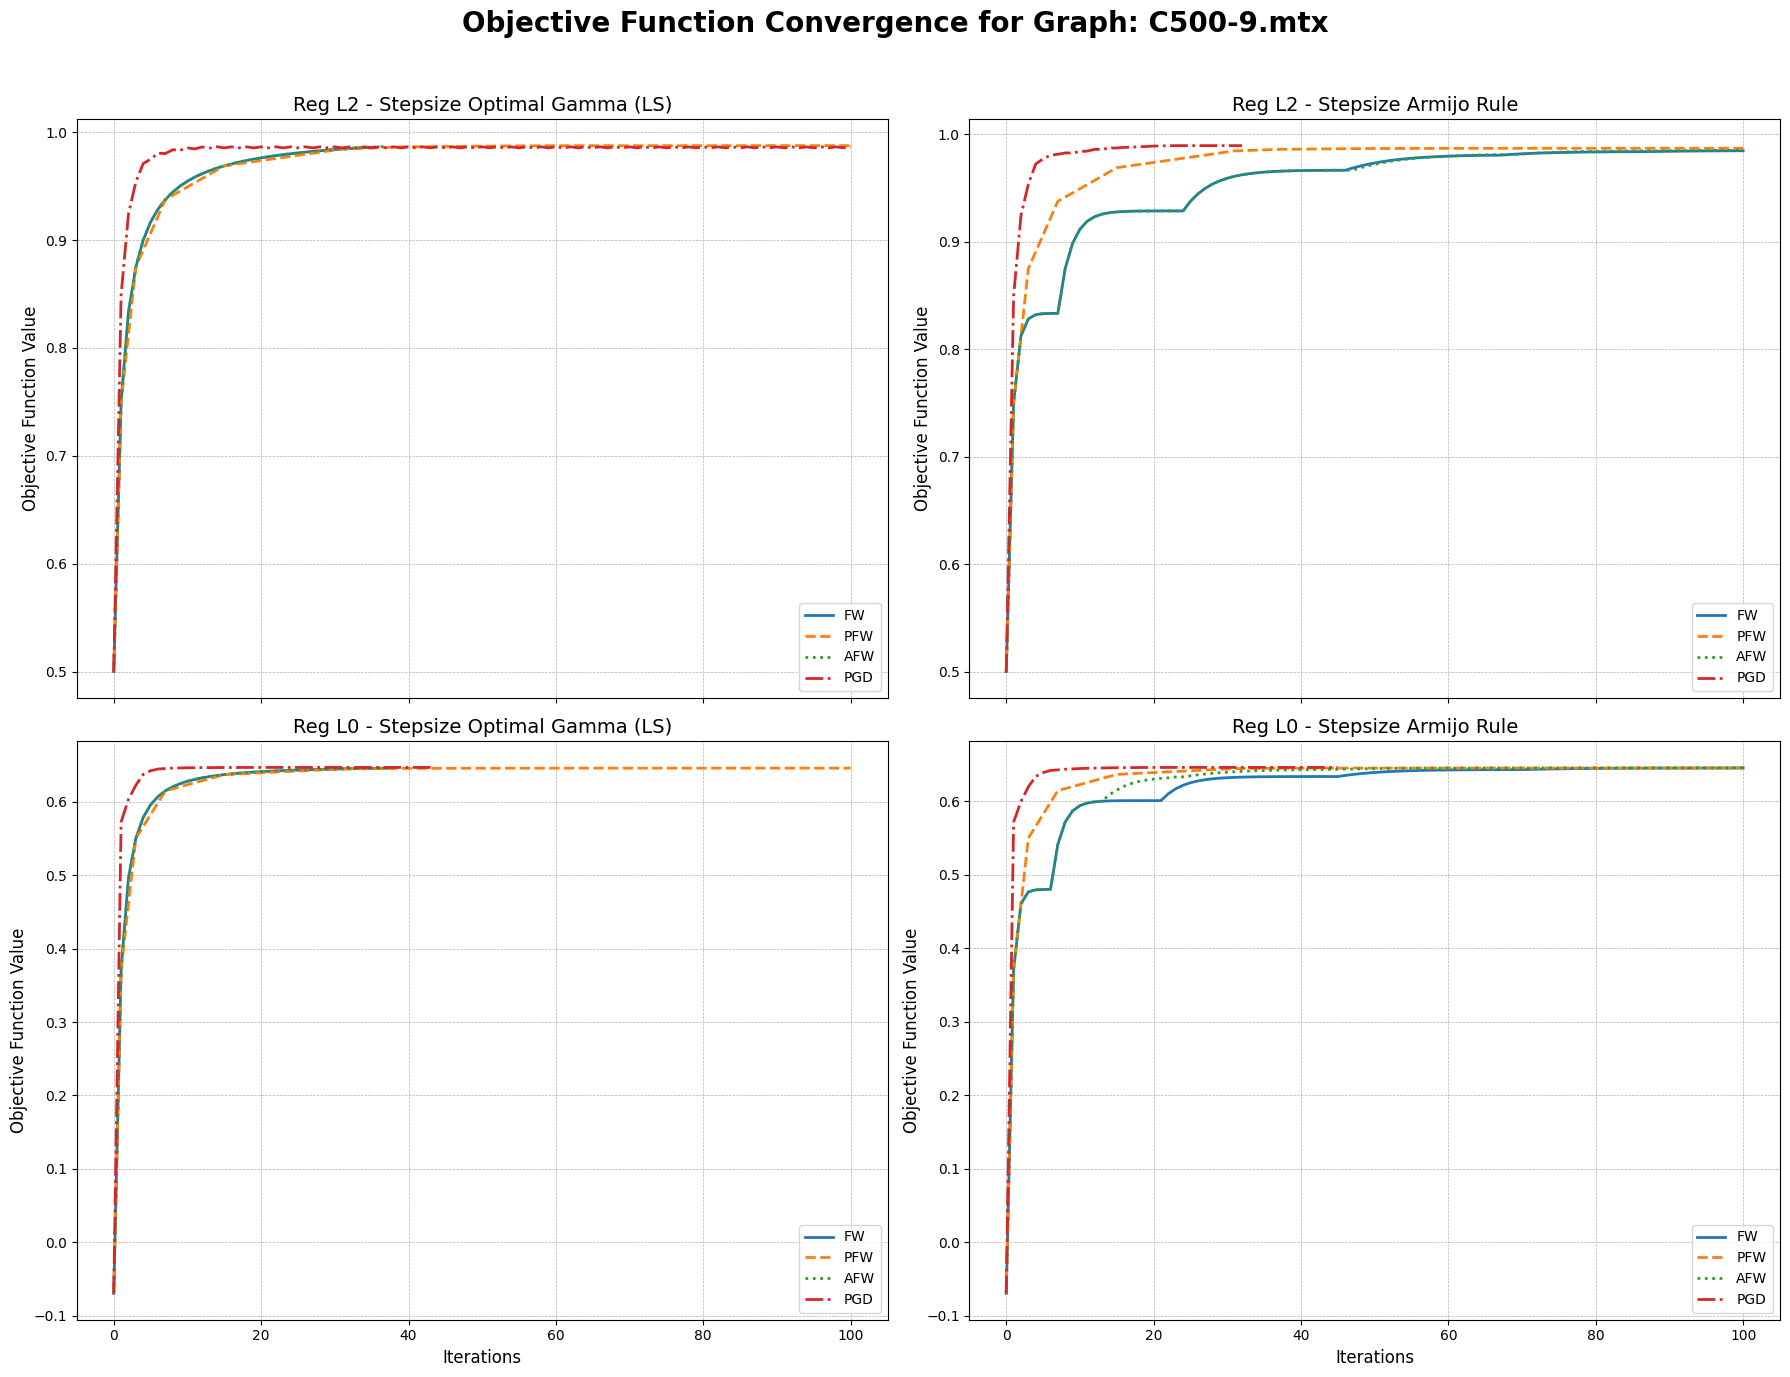

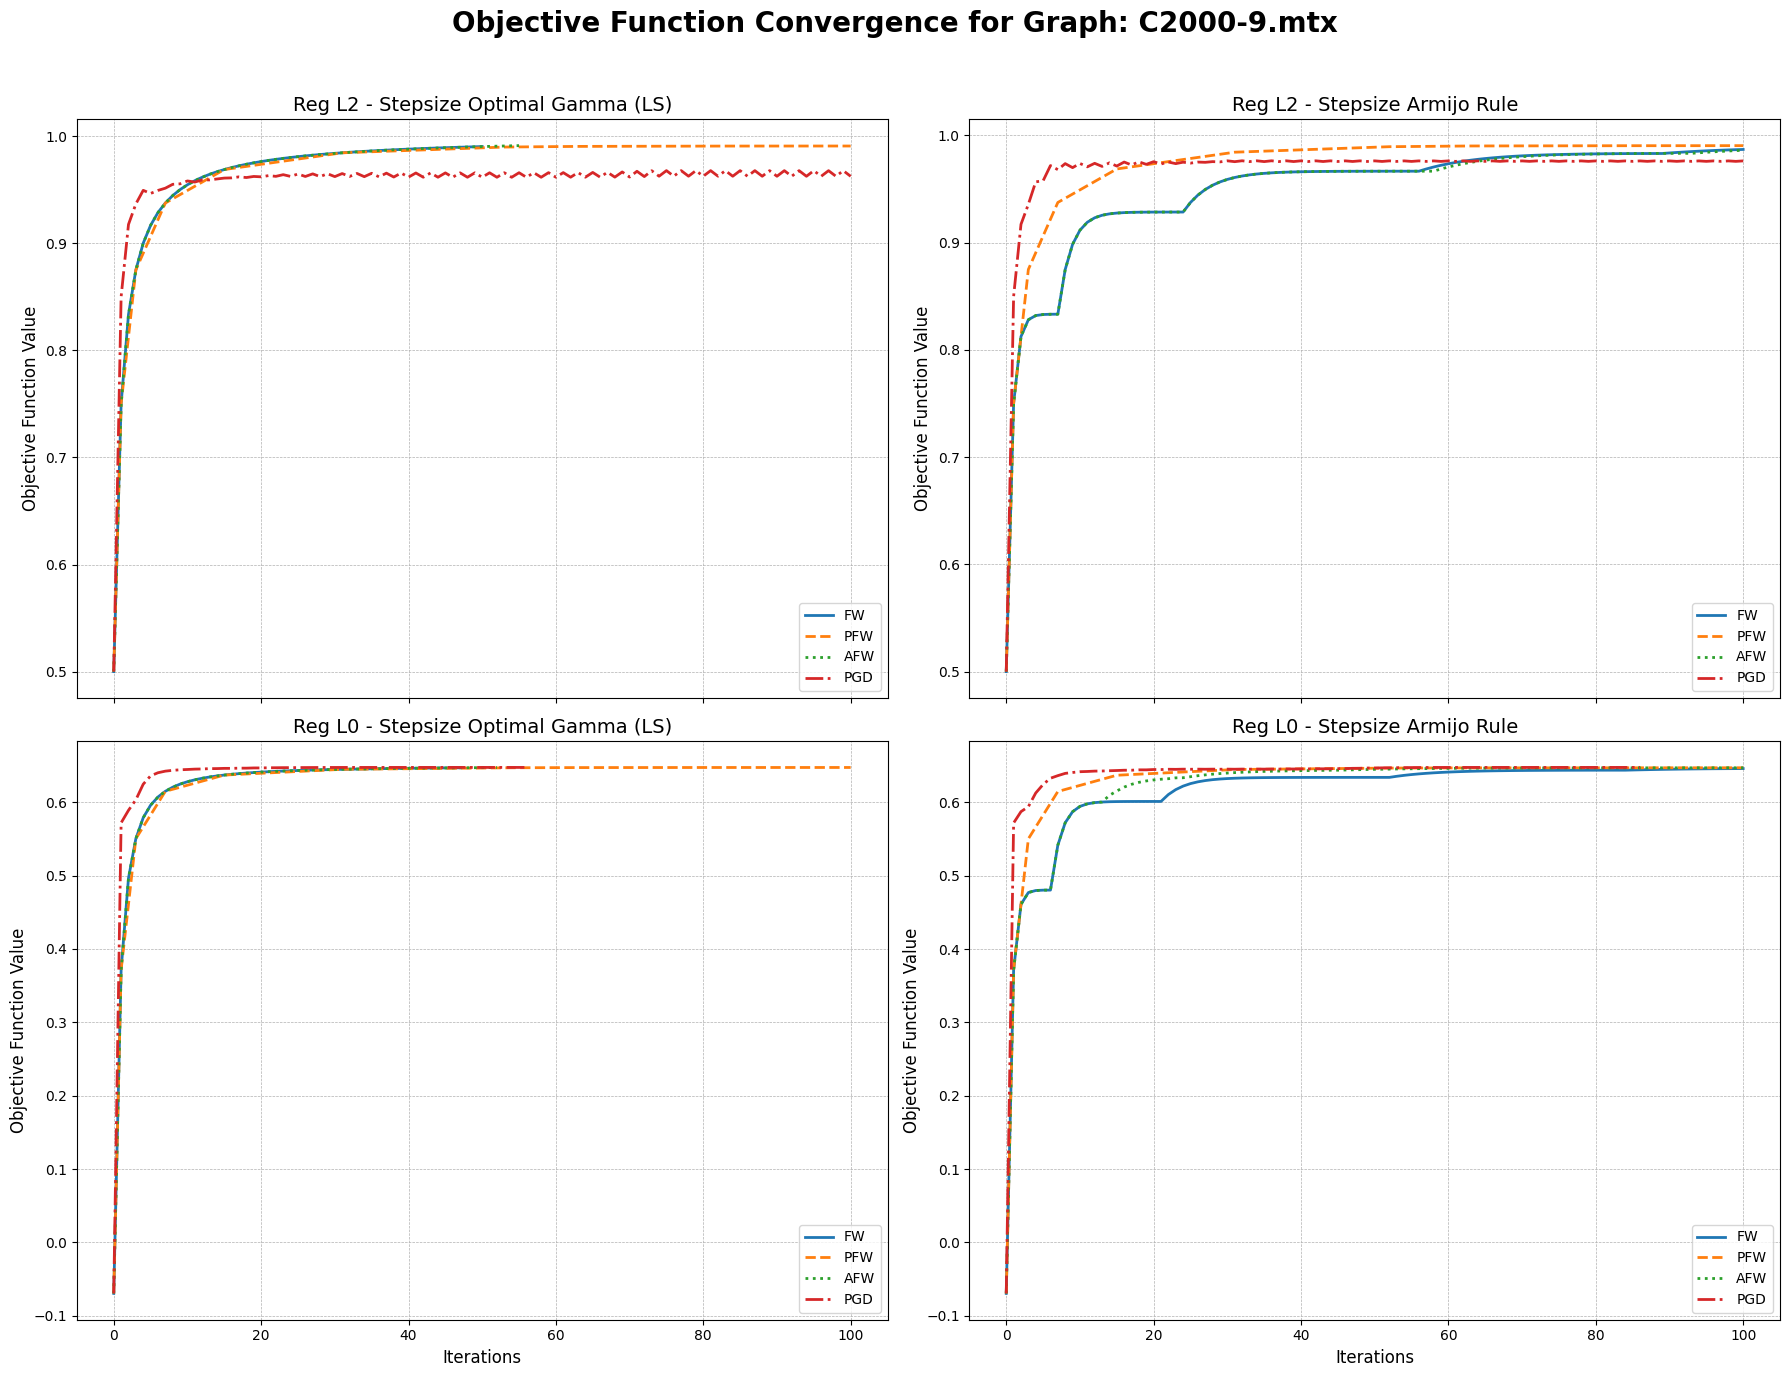

In [13]:

palette = {
    'FW': ('#1f77b4', '-'),   # Blu
    'PFW': ('#ff7f0e', '--'), # Arancione
    'AFW': ('#2ca02c', ':'),   # Verde
    'PGD': ('#d62728', '-.')  # Rosso
}

# Check if df_results exists and has the 'History' column
# Note: The df_results from cell 18/19 does NOT have 'History'.
# This code assumes a df_results *with* a 'History' column is available
# from a previous execution (e.g., similar to cell 12).
if 'df_results' not in locals() or 'History' not in df_results.columns:
    print("DataFrame 'df_results' not found or does not contain 'History' column.")
    print("Please ensure you have run an experiment cell that saves the 'History' list for each result.")
else:
    print("Generating Objective Function History plots...")

    # Get unique graph files from the DataFrame
    unique_graphs = df_results['Graph File'].unique()

    # Iterate over each graph file to create a separate figure
    for graph in unique_graphs:
        fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharex=True)
        fig.suptitle(f"Objective Function Convergence for Graph: {graph}", fontsize=20, fontweight='bold')

        # Filter DataFrame for the current graph
        df_graph = df_results[df_results['Graph File'] == graph]

        # Map for subplot titles and filtering conditions based on Reg and Stepsize labels
        plot_map = {
            (0, 0): ('Reg L2 - Stepsize Optimal Gamma (LS)', (df_graph['Reg'] == 'l2') & (df_graph['Stepsize'] == 'Optimal Gamma (LS)')),
            (0, 1): ('Reg L2 - Stepsize Armijo Rule', (df_graph['Reg'] == 'l2') & (df_graph['Stepsize'] == 'Armijo Rule')),
            (1, 0): ('Reg L0 - Stepsize Optimal Gamma (LS)', (df_graph['Reg'] == 'l0') & (df_graph['Stepsize'] == 'Optimal Gamma (LS)')),
            (1, 1): ('Reg L0 - Stepsize Armijo Rule', (df_graph['Reg'] == 'l0') & (df_graph['Stepsize'] == 'Armijo Rule'))
        }

        # Iterate through the map to create each subplot
        for (row, col), (title, condition) in plot_map.items():
            ax = axes[row, col]
            df_subset = df_graph[condition]

            if df_subset.empty:
                ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            else:
                # Plot the history for each algorithm in the subset
                for _, result_row in df_subset.iterrows():
                    algo = result_row['Algorithm']
                    history = result_row['History']
                    if history: # Check if history list is not empty
                        color, style = palette.get(algo, ('black', '-'))
                        ax.plot(history, label=algo, color=color, linestyle=style, linewidth=2)

            # Subplot settings
            ax.set_title(title, fontsize=14, fontweight='medium')
            ax.set_ylabel("Objective Function Value", fontsize=12)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            ax.legend()
            ax.tick_params(axis='both', which='major', labelsize=10)
            # Optional: Use a formatter if objective values are consistently small or large
            # ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))


        # Set common x-axis label for the bottom row
        for i in range(2):
            axes[1, i].set_xlabel("Iterations", fontsize=12)

        # Adjust layout to prevent titles/labels overlapping
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect leaves space for the suptitle

        # Display the figure
        plt.show()
